In [33]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import seaborn.objects as so
import shap


import xgboost as xgb 

from matplotlib.colors import LinearSegmentedColormap

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe
from src.data_processing.pipelines.custom_transformers.PreprocessingTransformer import PreprocessingTransformer
from src.utilities.pandas_helpers import filter_columns_by_search, flatten_dataframe

# Reproduce processing pipeline 

In [173]:
DATA_PATH = '/Users/mds8301/iterm_data_storage/raw_data_raw_data.parquet.gzip'
SUBJECT_ID_PATH = '/Users/mds8301/Development/ENIGMA/results/experiments/xgb_regression_hyperopt/subjects.json'
df = pd.read_parquet(DATA_PATH).query("sensor=='DA'")

In [174]:
def max_trials(df): 
    max_trials = (df[["mouse_id", "day", "trial", "action"]]
    .query("action == 'avoid'")
    .groupby(by=["mouse_id", "day", "action"])
            .max()
    .reset_index()
    .drop(columns=["action"])
    .rename(columns={"trial": "max_trial"})

    )
    max_trials
    return (
        df
        .merge(max_trials, on=["mouse_id", "day"], how="left")
        .drop_duplicates(
            subset=["mouse_id", "day"],
            keep="last")
        .reset_index(drop=True)
    )
    
max_trials(df)


,mouse_id,day,event,sensor,time,trial,signal,action,latency,sex,learning_phase,trial_count,max_trial
0,1,5,escape,DA,20.0,5,-0.513448,avoid,5.29,F,0,120,28.0
1,9,5,shock,DA,20.0,5,-0.642583,avoid,0.00,M,0,94,28.0
2,3,5,cue,DA,20.0,28,2.511740,avoid,0.00,M,2,138,28.0
3,7,5,avoid,DA,20.0,20,-0.231258,avoid,2.63,M,1,136,26.0
4,8,5,shock,DA,20.0,0,1.724476,escape,0.00,M,0,112,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,3,4,cue,DA,20.0,27,-0.804087,avoid,0.00,M,2,109,27.0
92,7,4,cue,DA,20.0,28,-1.216059,avoid,0.00,M,2,115,28.0
93,6,4,avoid,DA,20.0,25,-0.132028,avoid,1.72,F,2,83,28.0
94,8,4,avoid,DA,20.0,25,-0.684360,avoid,1.78,M,2,108,28.0


In [175]:

def calculate_percent_avoid_new(df):
    new_df= (
        df
        .query( "event=='cue' & sensor=='DA'")
        .drop(columns=["event", "time", 'signal','sex', 'sensor', 'learning_phase', 'trial_count', 'latency','trial'])
        .replace({"action": {"avoid": 1.0, "escape": 0.0}}).astype("float64")
        .groupby(by=["mouse_id", 'day'], as_index=False)
        .mean()
        # .rename(columns={"action": "ratio_avoid"})
        # # .assign(ratio_avoid=lambda df_: (df_.ratio_avoid.values.round(10)))
        # .drop_duplicates(subset=["mouse_id", "day"], keep="last")[["mouse_id", "day", "ratio_avoid"]].reset_index(drop=True)
        # .mean()
        # .rename(columns={"action": "ratio_avoid"})
        # .drop_duplicates(subset=["mouse_id", "day"], keep="last")[["mouse_id", "day", "ratio_avoid"]].reset_index(drop=True)


    )
    return new_df
    # merged_df = df.merge(new_df, on=["mouse_id", "day"], how="left")
    # return merged_df

In [176]:


def debug_df(df):
    print(df)
    return df


def calculate_max_min_signal(df, cols_to_drop=[]):

    events = filter_columns_by_search(df, 'event')
    actions = filter_columns_by_search(df, 'action')
    mouse = filter_columns_by_search(df, 'mouse')
    sensors = filter_columns_by_search(df, 'sensor')
    sex = filter_columns_by_search(df, 'sex')
    trial_count_bins = filter_columns_by_search(
        df, 'trial_count_bins')
    cols_to_group = mouse+events+actions+sensors+sex+trial_count_bins+['day', 'trial_count', 'trial']
    
    df = (
        df
        # .query("time > -10 and time < 10.1")
        .assign(
            neg_signal=lambda df_: np.where(df_.signal < 0, df_.signal, 0),
            pos_signal=lambda df_: np.where(df_.signal > 0, df_.signal, 0)
        )
        .groupby(by = cols_to_group
                 , as_index=False)
        .agg(
            {
                "signal": ["max", "min", np.trapz], 
                "pos_signal": np.trapz,
                "neg_signal": np.trapz
                }
            )
        .pipe(flatten_dataframe)
        .rename(columns=lambda c: c.strip("_"))
        .drop(columns='index')
        # .dropna()
    )
    df = df.drop(columns=cols_to_drop)
    return df


def calculate_percent_avoid_new(df):
    new_df= (
        df
        .drop(columns=['sex', 'sensor', 'trial_count',])
        .replace({"action": {"avoid": 1, "escape": 0}})
        .groupby(by=["mouse_id","day", "event"], as_index=False).mean()
        # .astype("float64")
        .rename(columns={"action": "ratio_avoid"})
        .drop_duplicates(subset=["mouse_id", "day"], keep="last")[["mouse_id", "day", "ratio_avoid"]].reset_index(drop=True)


    )
    merged_df = df.merge(new_df, on=["mouse_id", "day"], how="left")
    return merged_df
def standard_scale(df_):
    scaler = StandardScaler().set_output(transform='pandas')
    df_cat_cols = df_.select_dtypes(exclude = np.number)
    num_cols = df_.select_dtypes(include = np.number)
    df_to_scale = num_cols.drop(columns='ratio_avoid')
    df_scaled = scaler.fit_transform(df_to_scale)
    
    
    return(pd.concat([df_cat_cols, df_scaled], axis = 1)
                 .assign(ratio_avoid = df_.ratio_avoid))
                 

def expand_df(df):
    # debug_df(df)
  
    pivot_df = (
        df.pivot_table(index = ["ratio_avoid", "mouse_id", "day"],
                       columns = ["sensor","event"],
                       values =[col for col in df.columns if col not in ["ratio_avoid","sensor"]])
        # .drop(columns = ["mouse_id", "day"])

        )
    pivot_df.columns = ["_".join(col) for col in pivot_df.columns]
    return pivot_df.reset_index()

cols_to_drop = [ "action", "sex", "trial_count", "trial"]
      
      

# def df_pipeline(df_, *funcs: Callable):
#     return toolz.pipe(df_, *funcs)



def df_pipeline(df_):
  return(
    df_
    .pipe(calculate_max_min_signal)
    # .pipe(assign_ids)
    .pipe(calculate_percent_avoid_new)
    .drop(columns = cols_to_drop)
    .pipe(expand_df)
    .drop(columns = ['mouse_id', 'day'])
  )
# ids = assign_ids(df)
test_df = df_pipeline(df)
test_df


processor_pipe = ClassifierPipe(DATA_PATH)
processor_pipe.processed_data = test_df
processor_pipe.split_by_ratio(target = "ratio_avoid").transform_data()
processor_pipe.processed_data


,ratio_avoid,neg_signal_trapz_DA_avoid,neg_signal_trapz_DA_cue,neg_signal_trapz_DA_escape,neg_signal_trapz_DA_shock,pos_signal_trapz_DA_avoid,pos_signal_trapz_DA_cue,pos_signal_trapz_DA_escape,pos_signal_trapz_DA_shock,signal_max_DA_avoid,...,signal_max_DA_escape,signal_max_DA_shock,signal_min_DA_avoid,signal_min_DA_cue,signal_min_DA_escape,signal_min_DA_shock,signal_trapz_DA_avoid,signal_trapz_DA_cue,signal_trapz_DA_escape,signal_trapz_DA_shock
0,0.0,-175.680374,-167.158646,-171.241150,-174.943573,159.930649,165.179321,173.003891,171.078247,3.577325,...,4.986666,4.798352,-2.163916,-2.174700,-2.351609,-2.389435,-15.749731,-1.979335,1.762733,-3.865334
1,0.0,-162.030914,-166.663467,-181.359558,-180.819473,181.423279,167.092072,163.724335,163.230408,4.665627,...,3.470809,3.477009,-1.792376,-1.703143,-1.758063,-1.758867,19.392359,0.428599,-17.635229,-17.589060
2,0.0,-188.438995,-188.475937,-182.854126,-181.354370,178.818436,182.002396,225.591339,228.621902,4.469812,...,4.179577,4.377404,-2.138257,-2.162860,-2.447979,-2.518370,-9.620571,-6.473549,42.737228,47.267506
3,0.0,-187.598328,-182.339111,-217.391159,-198.629608,152.694260,159.902115,273.340790,289.223145,3.964172,...,5.222464,5.002191,-2.090872,-2.109405,-2.808737,-2.584502,-34.904079,-22.436991,55.949619,90.593544
4,0.0,-156.896820,-164.152283,-235.104416,-247.854660,192.241592,199.175629,227.439316,217.697083,3.443027,...,4.747762,4.778614,-1.785133,-1.827088,-2.159111,-2.210720,35.344769,35.023357,-7.665092,-30.157568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1.0,-183.375275,-180.726212,-252.993683,-252.885529,181.740265,183.750793,136.457840,137.336273,3.277046,...,3.247298,3.238914,-2.050364,-2.062605,-2.395465,-2.416087,-1.635001,3.024579,-116.535851,-115.549271
92,1.0,-192.717606,-184.584946,-268.689178,-270.515015,179.906921,177.026825,122.431038,121.545303,4.754360,...,5.420471,5.363124,-1.861220,-1.854003,-2.086705,-2.104770,-12.810680,-7.558132,-146.258148,-148.969711
93,1.0,-215.769089,-207.240372,-261.838837,-248.177307,169.799576,175.631638,120.482323,127.495354,3.300718,...,2.781533,2.833766,-2.016711,-1.951842,-1.979279,-1.932195,-45.969501,-31.608734,-141.356522,-120.681953
94,1.0,-190.794174,-195.882523,NaN,NaN,194.138947,188.402954,NaN,NaN,3.234605,...,NaN,NaN,-2.133203,-2.132184,NaN,NaN,3.344767,-7.479568,NaN,NaN


# MODEL

In [177]:
best_params = {'booster': 'gbtree', 'gamma': .001, 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 200, 'reg_lambda': .0010, 'subsample': 0.8}

model = xgb.XGBRegressor(
        objective='reg:squarederror', 
        eval_metric=['rmse', 'mae'],
        **best_params)
model.fit(processor_pipe.X_train, processor_pipe.y_train)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['rmse', 'mae'],
             feature_types=None, gamma=0.001, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [178]:
mse_train = mean_squared_error(processor_pipe.y_train, model.predict(processor_pipe.X_train))
mse_dev = mean_squared_error(processor_pipe.y_dev, model.predict(processor_pipe.X_dev))
mse_test = mean_squared_error(processor_pipe.y_test, model.predict(processor_pipe.X_test))
print(f" MSE for optimzied model on train is {mse_train}")
print(f" MSE for optimzied model on development test is {mse_dev}") 
print(f" MSE for optimzied model on test is {mse_test}")

 MSE for optimzied model on train is 0.0002604174391886871
 MSE for optimzied model on development test is 0.06907904749457493
 MSE for optimzied model on test is 0.11439452797471002


In [179]:
predicted_performance = model.predict(processor_pipe.X_test)

In [180]:
def get_cols_from_pipeline(pipeline):
        num_cols = pipeline.processor.named_transformers_["num"].get_feature_names_out().tolist()
        # cat_cols = pipeline.processor.named_transformers_["cat"].get_feature_names_out().tolist()
        return num_cols #+ cat_cols


def get_df_from_pipeline(pipeline, predicted_values):
        cols = get_cols_from_pipeline(pipeline)
        
        df = (pd.DataFrame(pipeline.X_test, columns=cols)
              .assign(predicted_values = predicted_values, 
                      true_values = pipeline.y_test.values))
        values_cat = ['predicted_values', 'true_values']

        return  (
                df
                .melt(id_vars = [col for col in df.columns if col not in values_cat],
                value_vars = values_cat, 
                var_name = "inference_cat",
                value_name='ratio_avoid')
        )
                
testing_df = get_df_from_pipeline(processor_pipe, predicted_performance)

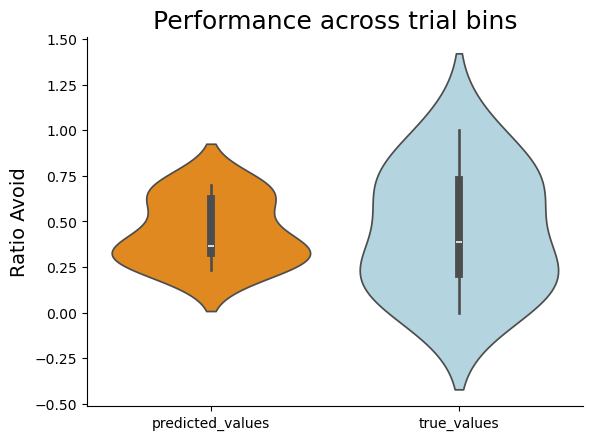

In [181]:
fig, ax = plt.subplots()
sns.violinplot(data=testing_df, x='inference_cat', y='ratio_avoid', hue='inference_cat', palette=['darkorange', 'lightblue'], ax = ax)


ax.set_xlabel('', fontsize=10)
ax.set_ylabel('Ratio Avoid', fontsize=14)
ax.set_title('Performance across trial bins', fontsize = 18)
sns.despine()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


Text(0.5, 1.0, 'Feature Importance')

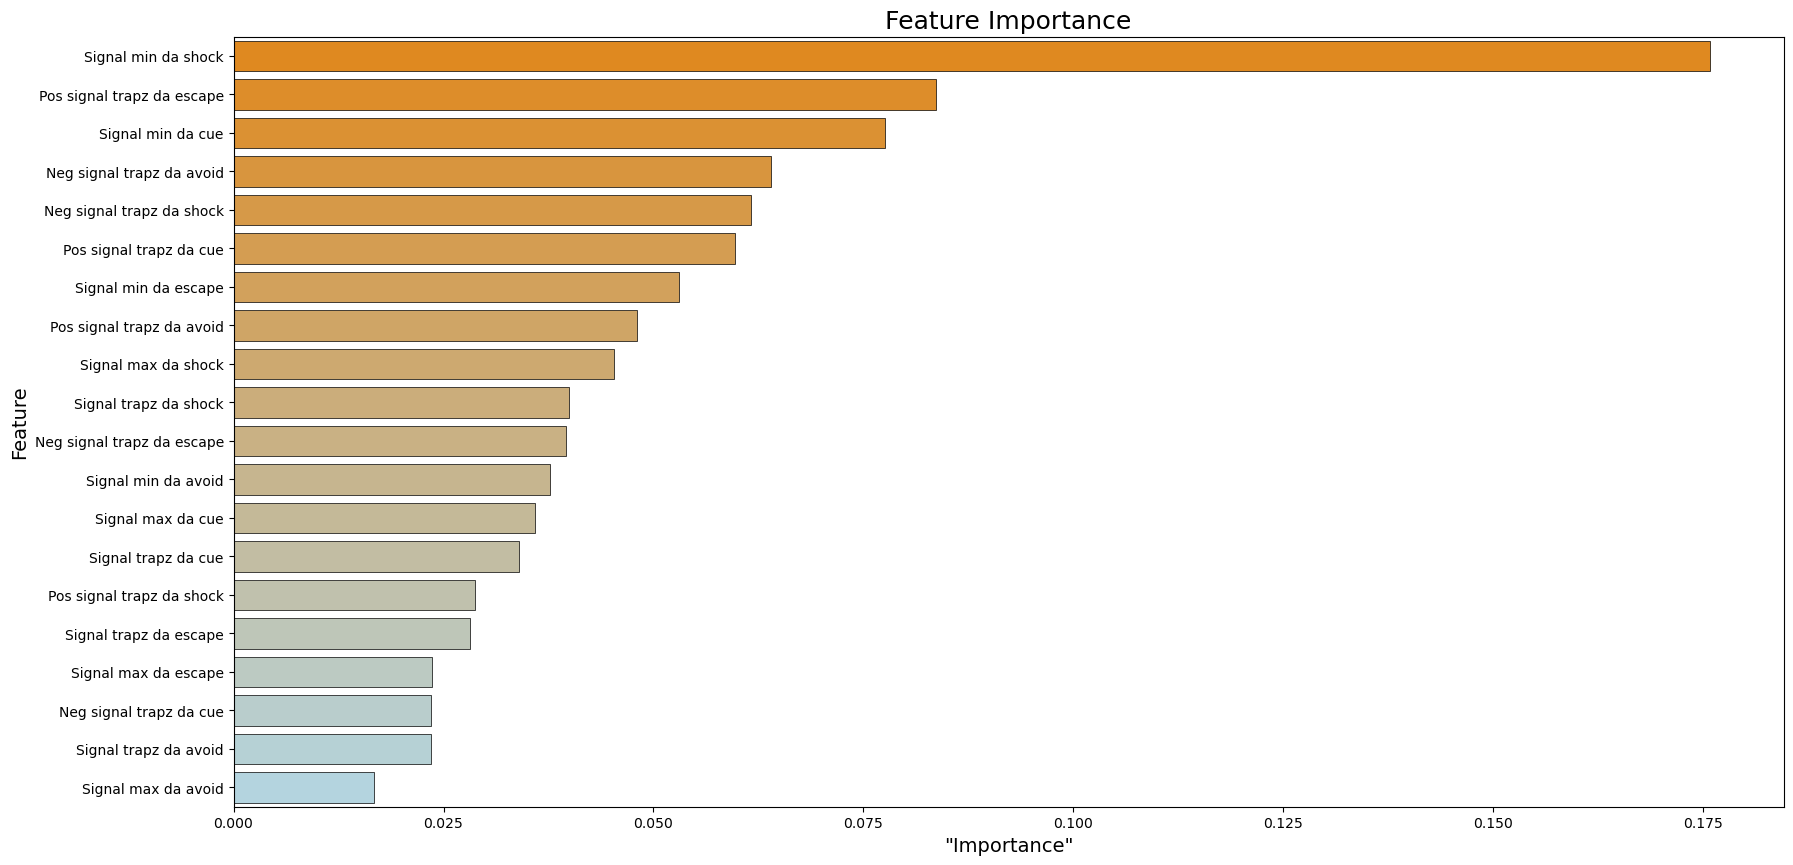

In [182]:
from matplotlib.colors import LinearSegmentedColormap


cols = get_cols_from_pipeline(processor_pipe)
# cols_new = [col.removeprefix("sensor_event_variable_") for col in cols]
feature_importance = (
    pd.Series(
    model.feature_importances_, index = cols)
    .sort_values(ascending=False)
)
color_map = LinearSegmentedColormap.from_list("orange_blue",["#FF8C00","#ADD8E6"])
colors = [color_map(i) for i in np.linspace(0, 1, len(feature_importance))]

# feature_importance
col_labels = [col.capitalize().replace('_', ' ') for col in feature_importance.index]
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x=feature_importance, y=feature_importance.index, ax=ax, linewidth=0.5, palette=colors, edgecolor='black')
ax.set_yticklabels(col_labels)
# ax.set_xscale("log")
ax.set_xlabel('"Importance"', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.set_title('Feature Importance', fontsize = 18)

[11:52:48] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


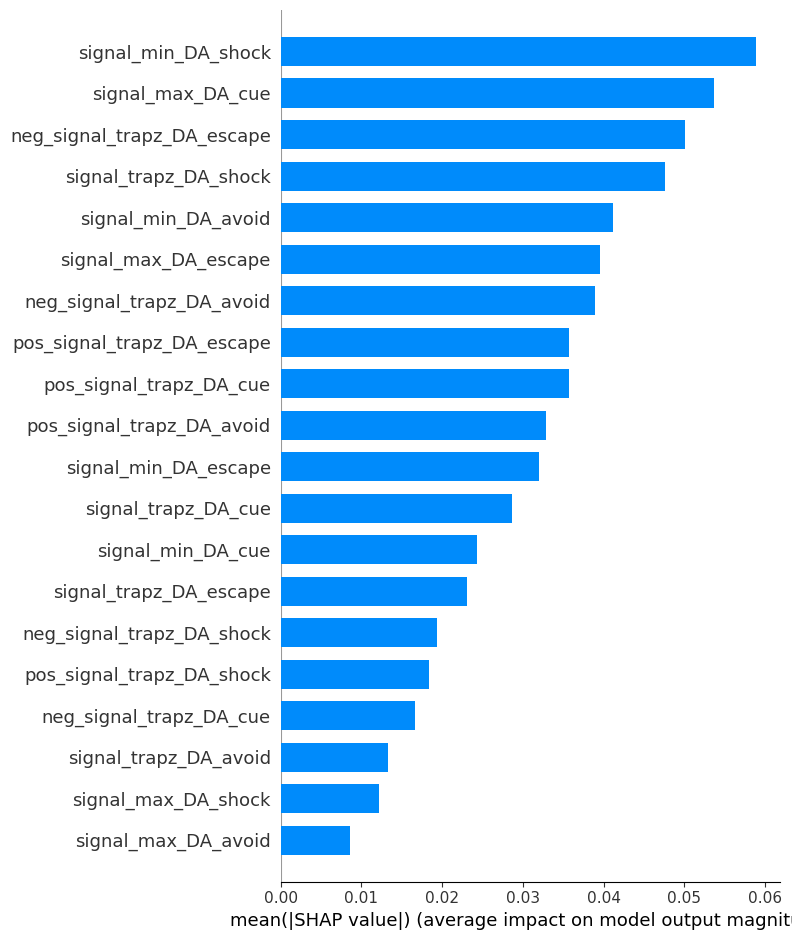

In [183]:

explainer = shap.TreeExplainer(model,processor_pipe.X_train)
explanation = explainer(processor_pipe.X_train)
explanation.feature_names = cols
shap.summary_plot(explanation, plot_type="bar")

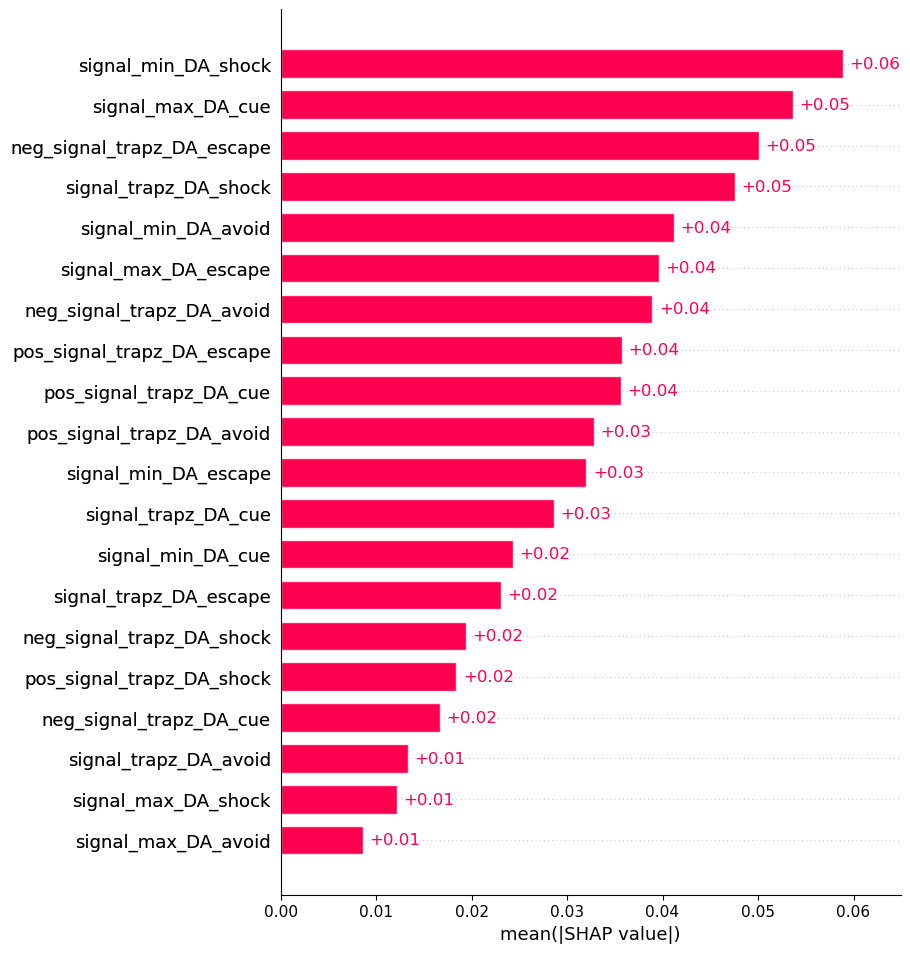

In [188]:
shap.plots.bar(explanation, max_display=20)

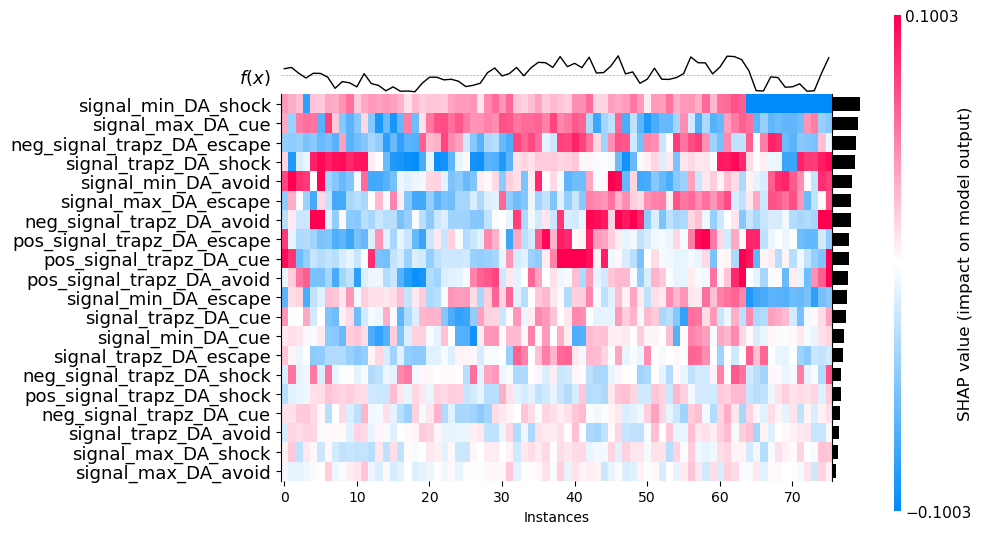

In [192]:
shap.plots.heatmap(explanation, max_display=20)

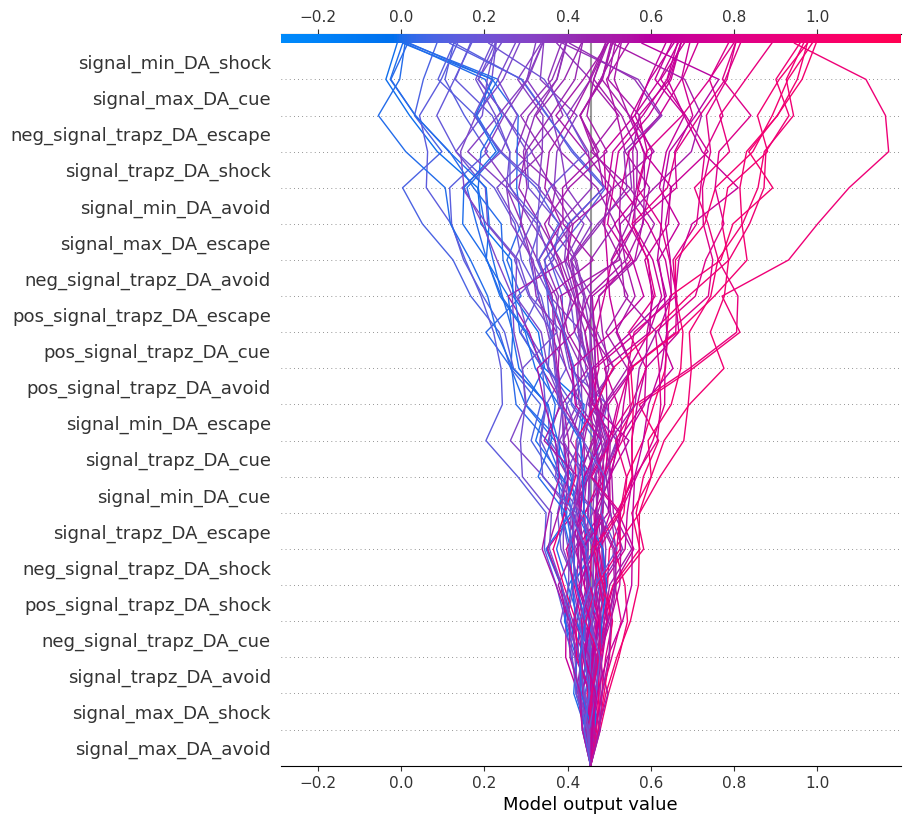

In [213]:
shap.decision_plot(explainer.expected_value, explanation.values, feature_names=cols)


TypeError: 'builtin_function_or_method' object is not subscriptable

/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_75694/4240870877.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="../conf", config_name="quest_conf")
usage: ipykernel_launcher.py [--help] [--hydra-help] [--version]
                             [--cfg {job,hydra,all}] [--resolve]
                             [--package PACKAGE] [--run] [--multirun]
                             [--shell-completion] [--config-path CONFIG_PATH]
                             [--config-name CONFIG_NAME]
                             [--config-dir CONFIG_DIR]
                             [--experimental-rerun EXPERIMENTAL_RERUN]
                             [--info [{all,config,defaults,defaults-tree,plugins,searchpath}]]
                             [overrides ...]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/mds8301/Library/Jupyter/runtime/kernel

SystemExit: 2

/Users/mds8301/anaconda3/envs/enigma_xgb/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
